# Homework 4 - Applied ML

## Importing useful packages

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)

%matplotlib inline

## Question 1: Propensity score matching

In this exercise we are analyzing an observational study in different ways to show that it is important to be cautious when interpreting such results.

The file lalonde.csv contains data about people who either got treated or not and the outcome of the experiment.

In [2]:
lalonde = pd.read_csv('lalonde.csv')
lalonde.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


The column **'treat'** specifies whether the person was treated or not. The columns **'black'** and **'hispan'** are derived from a categorical variable **'race'** which can take the values 'black', 'hispan' and 'white'. When both black and hispan are 0, it means that the person is white. Deriving this categorical variable improve the performances of the machine learning algorithms that we will use.

Let's make a column for race :

In [3]:
lalonde['race'] = 'white'
lalonde.loc[lalonde['black'] == 1, 'race'] = 'black'
lalonde.loc[lalonde['hispan'] == 1, 'race'] = 'hispanic'

Let's look the data frame in more detail :

In [4]:
lalonde.describe().round(1)

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,614.0,614.0,614.0,614.0,614.0,614.0,614.0,614.0,614.0,614.0
mean,0.3,27.4,10.3,0.4,0.1,0.4,0.6,4557.5,2184.9,6792.8
std,0.5,9.9,2.6,0.5,0.3,0.5,0.5,6478.0,3295.7,7470.7
min,0.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,20.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,238.3
50%,0.0,25.0,11.0,0.0,0.0,0.0,1.0,1042.3,601.5,4759.0
75%,1.0,32.0,12.0,1.0,0.0,1.0,1.0,7888.5,3249.0,10893.6
max,1.0,55.0,18.0,1.0,1.0,1.0,1.0,35040.1,25142.2,60307.9


### 1. A naive analysis

Let's naively check if the salary of those who are treated is higher than the salary of those who are not.

There are way less treated people than untreated ones in the data set :

In [5]:
treat = lalonde['treat'] == 1
untreat = lalonde['treat'] == 0

print('There are {0} treated people and {1} untreated ones.'.format(len(lalonde[treat]), len(lalonde[untreat])))

There are 185 treated people and 429 untreated ones.


We can check here that the treated group has a lower salary in average (~6350) than the untreated group (~6980) even if the maximum is about 3 times bigger in the treated group (it is probably an outlier). The maximum is indeed not robust and if we compare the 75%-quantile, we can see that it is higher for the untreated group.

In [6]:
lalonde[treat]['re78'].describe().round(1)

count      185.0
mean      6349.1
std       7867.4
min          0.0
25%        485.2
50%       4232.3
75%       9643.0
max      60307.9
Name: re78, dtype: float64

In [7]:
lalonde[untreat]['re78'].describe().round(1)

count      429.0
mean      6984.2
std       7294.2
min          0.0
25%        220.2
50%       4975.5
75%      11688.8
max      25564.7
Name: re78, dtype: float64

Let's plot the histograms of the salaries **re78** for both treated and untreated groups :

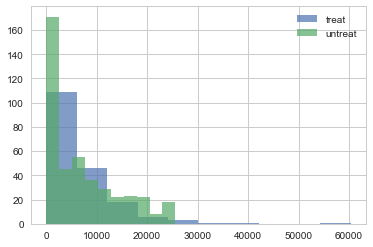

In [8]:
lalonde[treat]['re78'].hist(alpha=0.7, label='treat')
lalonde[untreat]['re78'].hist(alpha=0.7, label='untreat')
plt.legend(loc='upper right')

The salaries of the treated group are more spread : there are more very high values and less low values. But in average it is lower than the untreated group. The boxplots may help to have a clearer view of things :

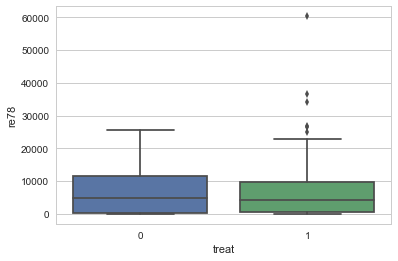

In [9]:
sns.boxplot(x='treat', y='re78', data=lalonde);

There are indeed several outliers in the treated group. Let's zoom in by not plotting those outliers :

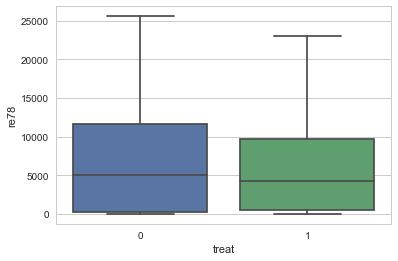

In [10]:
sns.boxplot(x='treat', y='re78', data=lalonde, showfliers=False);

Now we see that the treated group seemed more spread because of the outliers. The values between the 25% and the 75% quantiles are indeed more concentrated here.

**A naive researcher might conclude from these observations that the treatment is useless since the treated group has in average lower salaries than the untreated one.**

### 2. A closer look at the data

Let's try to have a deeper understanding of the data. This is an observational study and we have to be cautious with these results. Latent factors might indeed influence both the fact that someone is treated and his salary.

Let's look at the distributions of the features for each group and understand of what people they are composed.

**Age distribution :**

Here is a function that can be used to describe a feature in both groups at the same time :

In [11]:
def describe_feature(feature, x='treat'):
    return lalonde[lalonde[x] != -1].groupby(x)[feature].describe().round(1)

In [12]:
describe_feature('age')

,count,mean,std,min,25%,50%,75%,max
treat,,,,,,,,
0,429.0,28.0,10.8,16.0,19.0,25.0,35.0,55.0
1,185.0,25.8,7.2,17.0,20.0,25.0,29.0,48.0


It seems like there is no huge difference between the ages of the two groups. The treated group is a little younger in average. We can plot the distributions of the features and use boxplots for more interpretability. Here is a function taking the feature name in argument and making the plots :

In [13]:
'matched_treat' in lalonde.columns

False

In [14]:
def compare_feature(feature, x='treat', show_outliers=False):
    fig, subplots = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    plt.subplot(1, 2, 1)

    group = lalonde[lalonde[x] != -1].groupby(x)[feature]
    for k, v in group:
        label = 'treat'
        if k == 0:
            label = 'untreat'
        v.hist(label=label, alpha=0.5)
    plt.legend(loc='upper right')
    plt.title(feature + ' distribution')
    
    #lalonde[untreat][feature].hist(alpha=0.5, label='untreat')
    #lalonde[treat][feature].hist(alpha=0.5, label='treat')
    #plt.legend(loc='upper right')

    plt.subplot(1, 2, 2)
    
    sns.boxplot(x=x, y=feature, data=lalonde[lalonde[x] != -1], showfliers=show_outliers)
    #df = pd.DataFrame()

    #df[feature + ' untreat'] = lalonde[untreat][feature].reset_index(drop=True)
    #df[feature + ' treat'] = lalonde[treat][feature].reset_index(drop=True)

    #pd.DataFrame.boxplot(df, column=[feature + ' treat', feature + ' untreat'], showfliers=show_outliers)

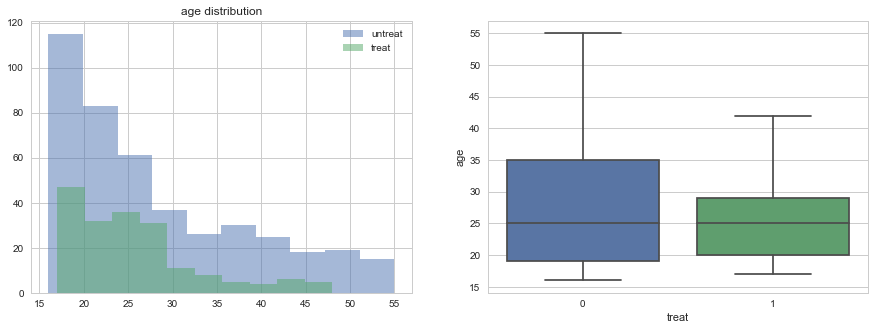

In [15]:
compare_feature('age')

Here we see clearly that even if they are the same in average, there are more older people in the untreated group.

**Education distribution :**

In [16]:
describe_feature('educ')

,count,mean,std,min,25%,50%,75%,max
treat,,,,,,,,
0,429.0,10.2,2.9,0.0,9.0,11.0,12.0,18.0
1,185.0,10.3,2.0,4.0,9.0,11.0,12.0,16.0


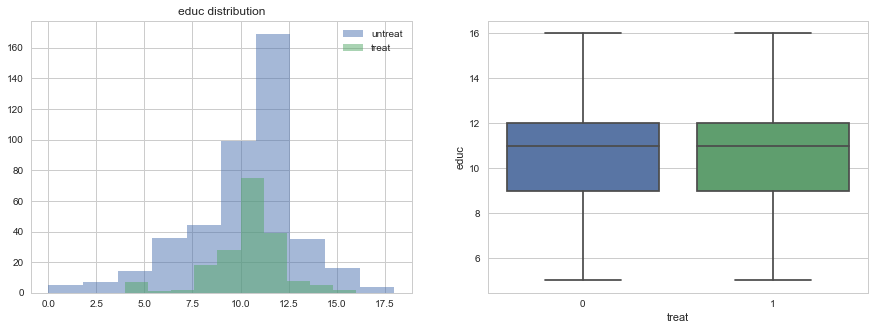

In [17]:
compare_feature('educ')

The two groups have pretty much the same number of years of education.

**Marital, degree and race distributions :**

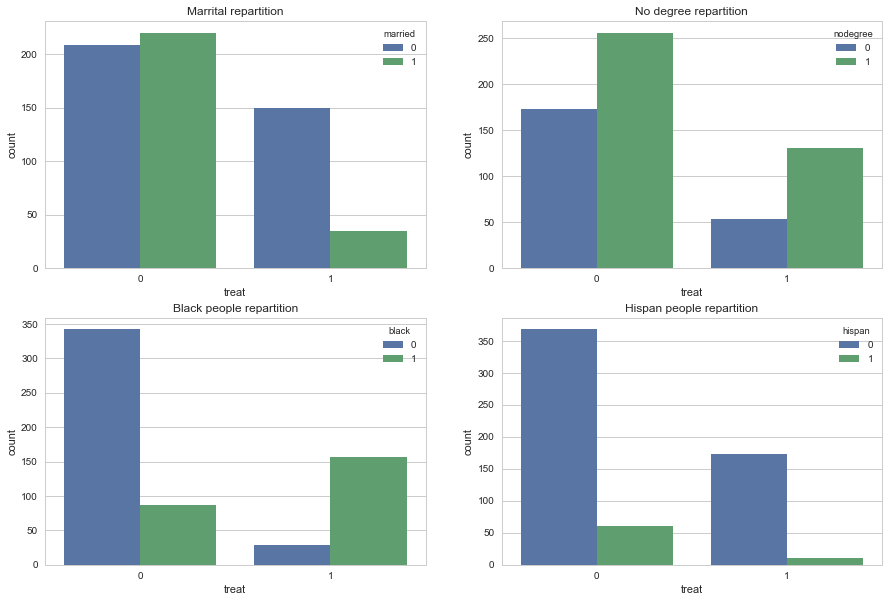

In [18]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

ax[0, 0].set_title("Marrital repartition")
sns.countplot(x='treat', hue='married', data=lalonde, ax=ax[0, 0])

ax[0, 1].set_title("No degree repartition")
sns.countplot(x='treat', hue='nodegree', data=lalonde, ax=ax[0, 1])

ax[1, 0].set_title("Black people repartition")
sns.countplot(x='treat', hue='black', data=lalonde, ax=ax[1, 0])

ax[1, 1].set_title("Hispan people repartition")
sns.countplot(x='treat', hue='hispan', data=lalonde, ax=ax[1, 1])

There are only **~20%** married people in the treated group and almost **50%** in the untreated one. The values of this feature are clearly different between the two groups.

It shows that ~70% of the people in the treated group have no degree, while it is only ~60% for the untreated group. We could not really guess that difference from the number of years of education distribution because the years before college are also taken in consideration, which makes the means very close. Finally it shows that the treated group is a little less educated than the untreated one.

There are about **85%** of black people in the treated group and only **20%** in the untreated one.

On the contrary, there are more hispan people in the untreated group (**~15%**) than in the treated one (**~5%**). But these two last features show that there are only **~10%** white people in the treated group and **~65%** in the untreated group.

**The age, education and race distributions show that in average, the treated group is composed of weaker people who tend to have more difficulties and lower salaries : young people, with lower education, and a majority of non-white people.**

Let's see if the salary distributions confirm it :

**Salary in 74 distribution :**

In [19]:
describe_feature('re74')

,count,mean,std,min,25%,50%,75%,max
treat,,,,,,,,
0,429.0,5619.2,6788.8,0.0,0.0,2547.0,9277.1,25862.3
1,185.0,2095.6,4886.6,0.0,0.0,0.0,1291.5,35040.1


It shows that the salary of the treated group is much lower than the untreated group before the treatment (about 2.5 times lower)

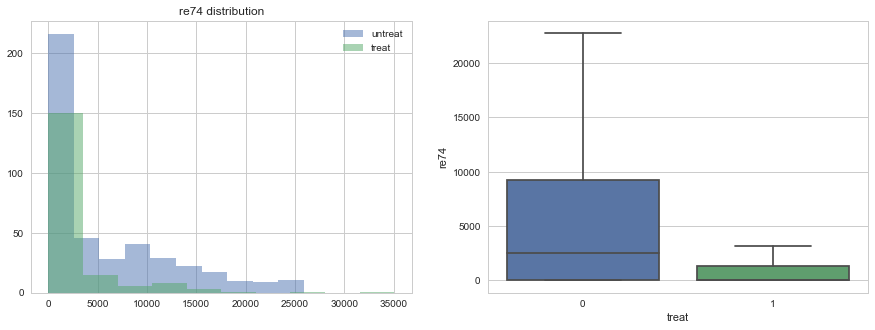

In [20]:
compare_feature('re74')

These two plots confirm that the salaries of the untreated people tend to be much higher.

**Salary in 75 distribution :**

In [21]:
describe_feature('re75')

,count,mean,std,min,25%,50%,75%,max
treat,,,,,,,,
0,429.0,2466.5,3292.0,0.0,0.0,1086.7,3881.4,18347.2
1,185.0,1532.1,3219.3,0.0,0.0,0.0,1817.3,25142.2


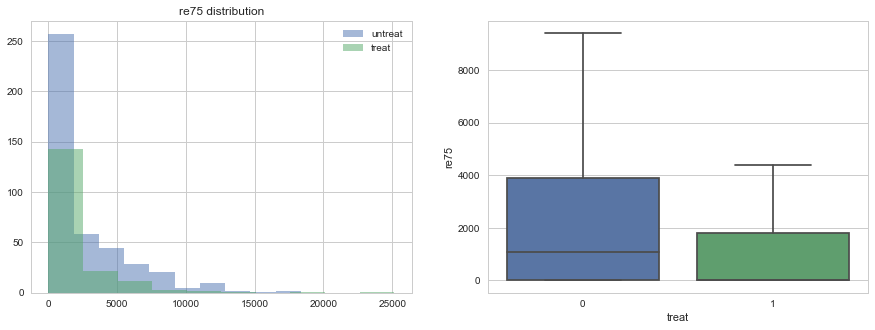

In [22]:
compare_feature('re75')

Once again the salaries of the treated group are much lower than in the untreated group.

### 3. A propensity score model

We just observed in the part **2.** that the two groups, the treated one and the untreated one, are very disparate. Thus, comparing the salaries in 78 is not really relevant. In this part, we are trying to figure out what underlying relation exists between the features and whether a person got treated or not. To do so, we are using a logistic regression and calculating the propensity scores of each data point.

In [23]:
from sklearn import linear_model

logistic = linear_model.LogisticRegression()

lalonde.head().round(1)

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,race
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0,black
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.9,hispanic
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4,black
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1,black
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.8,black


We only keep the features before the treatment. The categorical features are binary so we don't need to change them.

In [24]:
features = ['age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75']

X = lalonde[features]
y = lalonde.treat

logistic.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

After the model is trained, we can get the probability for each row to be treated or not.

In [25]:
probabilities = logistic.predict_proba(X)
probabilities

array([[ 0.55664958,  0.44335042],
       [ 0.85534047,  0.14465953],
       [ 0.27764537,  0.72235463],
       ..., 
       [ 0.87687096,  0.12312904],
       [ 0.44954003,  0.55045997],
       [ 0.84497047,  0.15502953]])

The first column is the probability not to be treated and the second one is the probability to be treated. We keep only the second one :

In [26]:
propensity = probabilities[:, 1]

### 4. Balancing the dataset via matching

We can use these propensity scores to match people from the treated group with people from the untreated group. Two people are matched if they look similar. Since there are more people in the untreated group, each people from the treated group will be matched with exactly on from the untreated one.

We are using the package networkx to do so. It contains a function max_weight_matching matching nodes by pair in a graph. The nodes can only be matched if they're linked together. So each node from the treated group will be linked to the nodes from the untreated group, and the weight will be the absolute value of the difference of the propensity scores. However, we want exactly the opposite of what the function max_weight_matching does : it tries to maximize the sum of the weights of the links between all the pairs, while we want to minimize it. So we just have to take a number higher than all the weights, and substract the adjacency matrix to it in order to make the algorithm work the way we want.

In [27]:
import networkx as nx

In [28]:
tile = np.tile(propensity, (len(propensity), 1))

#Every node is linked to all the other ones with the absolute value of the differences of propensity scores.
adj = np.abs(tile - tile.T)

np.max(adj)

0.76906945869021848

We can just take the number 1 since it is higher than all the weights :

In [29]:
adj = 1 - adj

#Finally we don't want nodes from the treated group to be linked together, and nodes from the untreated group to be
#linked together
treat_index = lalonde[lalonde['treat'] == 1].index.values
untreat_index = lalonde[lalonde['treat'] == 0].index.values

adj[treat_index.reshape((len(treat_index), 1)), treat_index] = 0
adj[untreat_index.reshape((len(untreat_index), 1)), untreat_index] = 0

Creating the graph and running the algorithm :

In [30]:
g = nx.Graph(adj)

matching = nx.max_weight_matching(g)

In [31]:
pairs = [frozenset(x) for x in list(matching.items())]
pairs = set(pairs)
pairs = np.array([[x, y] if lalonde.iloc[x]['treat'] == 1 else [y, x] for x, y in pairs])

Finally the value that we tried to minimize is the sum of the absolute value of the differences of propensity scores between the pairs :

In [32]:
np.sum(np.abs(propensity[pairs[:, 0]] - propensity[pairs[:, 1]]))

35.413291903349474

We can check that the pairs are correctly ordered (the first column is composed of treated people and the second one of untreated people) :

In [33]:
for x in pairs:
    if lalonde.iloc[x[0]]['treat'] == lalonde.iloc[x[1]]['treat']:
        print(x)

**Comparaison of the incomes re78 between the two matched groups**

Let's redefine the treat and untreat variables with the matched values :

In [34]:
treat_matched = pairs[:, 0]
untreat_matched = pairs[:, 1]

We create a categorical column **'match_treat'** in the **lalonde** data frame : 0 means that the person was matched and is untreated, and 1 means that the person was matched and treated (-1 means the person wasn't matched).

In [35]:
lalonde['match_treat'] = -1
lalonde.loc[untreat_matched, 'match_treat'] = 0
lalonde.loc[treat_matched, 'match_treat'] = 1

In [36]:
describe_feature('re78', x='match_treat')

,count,mean,std,min,25%,50%,75%,max
match_treat,,,,,,,,
0,185.0,5312.5,5842.9,0.0,0.0,3392.9,7933.9,20243.4
1,185.0,6349.1,7867.4,0.0,485.2,4232.3,9643.0,60307.9


With these matchings, the treated group has now a higher income in average than the untreated one.

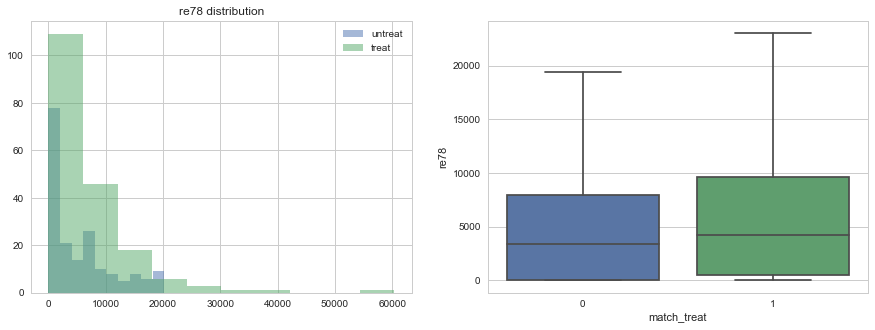

In [37]:
compare_feature('re78', x='match_treat')

These plots clearly show the difference : now the salaries are higher in the treated group. It confirms the intuition we had earlier : the treated group is composed in average of "weaker" people with lower salaries. Comparing their income after the treatment with the untreated group is unfair and that's why the treatment seemed unefficient. These new plots compare people who are similar.

**Let's see how similar the two matched groups are :**

**Age feature :**

In [38]:
describe_feature('age', x='match_treat')

,count,mean,std,min,25%,50%,75%,max
match_treat,,,,,,,,
0,185.0,23.7,9.6,16.0,17.0,19.0,26.0,55.0
1,185.0,25.8,7.2,17.0,20.0,25.0,29.0,48.0


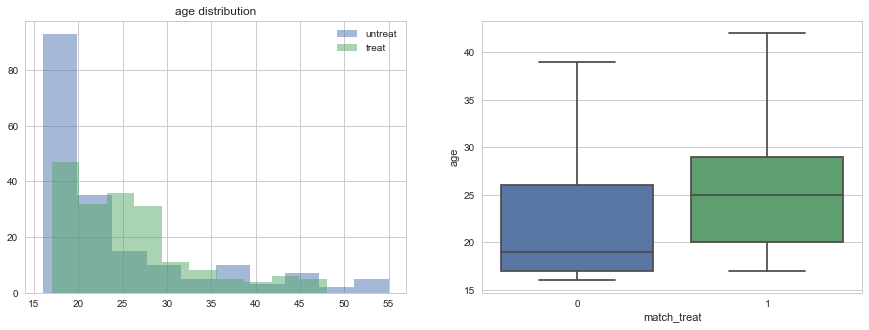

In [39]:
compare_feature('age', x='match_treat')

Now the untreated group is younger than the treated one. The distributions don't really match.

**Education feature :**

In [40]:
describe_feature('educ', x='match_treat')

,count,mean,std,min,25%,50%,75%,max
match_treat,,,,,,,,
0,185.0,10.2,2.9,0.0,9.0,10.0,12.0,18.0
1,185.0,10.3,2.0,4.0,9.0,11.0,12.0,16.0


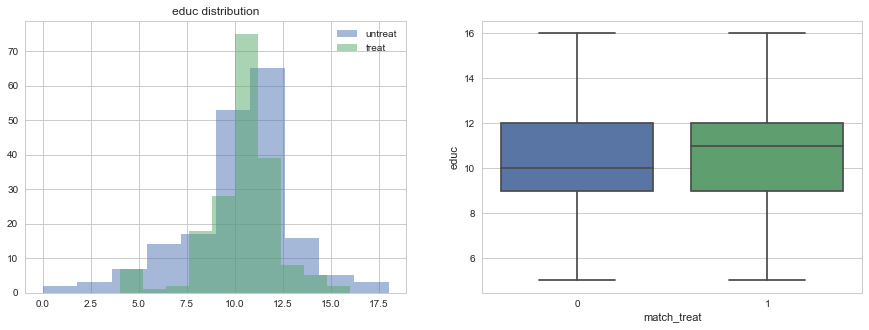

In [41]:
compare_feature('educ', x='match_treat')

The differences are smaller for the education, but the untreated group is also now less educated.

**Marrital, degree and race features :**

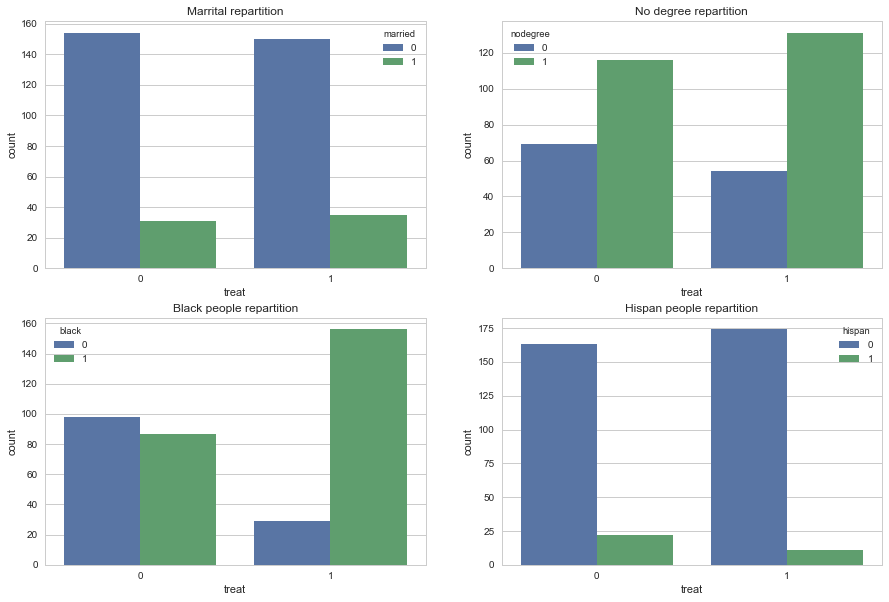

In [42]:
df = lalonde[lalonde['match_treat'] != -1]

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

ax[0, 0].set_title("Marrital repartition")
sns.countplot(x='treat', hue='married', data=df, ax=ax[0, 0])

ax[0, 1].set_title("No degree repartition")
sns.countplot(x='treat', hue='nodegree', data=df, ax=ax[0, 1])

ax[1, 0].set_title("Black people repartition")
sns.countplot(x='treat', hue='black', data=df, ax=ax[1, 0])

ax[1, 1].set_title("Hispan people repartition")
sns.countplot(x='treat', hue='hispan', data=df, ax=ax[1, 1])

The races of the two groups are now closer to each other (**47%** of black people now in the untreated group instead of **20%**). There are also a little less hispan people, which makes the two rates closer. However we see that there is still a big gap between the two populations.

**Income features :**

In [43]:
describe_feature('re74', x='match_treat')

,count,mean,std,min,25%,50%,75%,max
match_treat,,,,,,,,
0,185.0,2095.9,4029.2,0.0,0.0,290.0,2069.0,21918.3
1,185.0,2095.6,4886.6,0.0,0.0,0.0,1291.5,35040.1


Now the incomes are very similar between the two groups. The mean are almost the same here, and we can check that the distributions look also very similar :

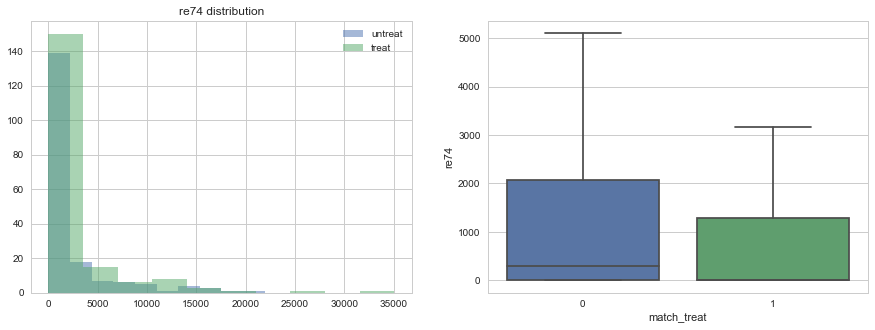

In [44]:
compare_feature('re74', x='match_treat')

In [45]:
describe_feature('re75', x='match_treat')

,count,mean,std,min,25%,50%,75%,max
match_treat,,,,,,,,
0,185.0,1615.3,2674.7,0.0,0.0,451.2,1890.6,13776.5
1,185.0,1532.1,3219.3,0.0,0.0,0.0,1817.3,25142.2


Same for the incomes re75 which are now very similar.

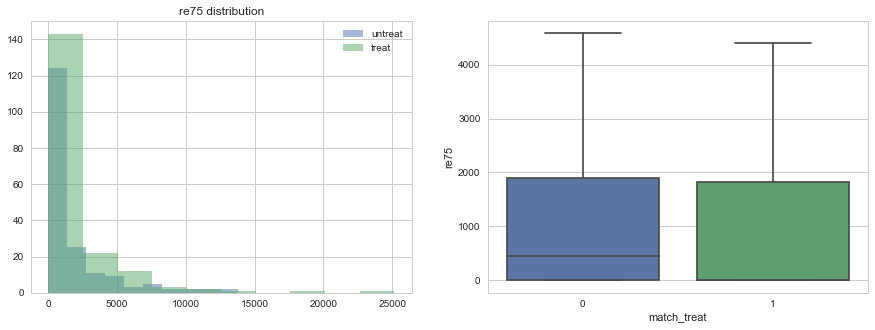

In [46]:
compare_feature('re75', x='match_treat')

Here is the interpretation that we can make after the analysis of these plots : the main features influencing the **treat** column are the incomes **re74** and **re75**, so to make the propensity scores similar, the matching had to make these incomes close between the two groups. Moreover we can expect that features like the age, the race or the education directly influence these incomes. That's why the age and the education got lowered in the new untreated group and there are now more black people.

All the distributions are now closer after this matching using propensity scores. It means that the two compared populations are similar. The conclusions that we can draw from this are thus more relevant than the previous ones : the treatment has an impact on the salary.

### 5. Balancing the groups further

After the observations made in the part **4.**, we feel like that even if the matched pairs help to make a deeper analysis, we could not match the groups well enough to make the two populations totally similar. It comes from the fact that the two initial populations, the treated one and the untreated one, are too different and we can't match them completly using propensity scores. The last part shows that we managed to match the incomes very well, and the age and the education are also pretty well balanced. However, the race distributions are still very different even after the matching : there are still way more black people in the treated group than in the untreated one. It leads us to think that the conclusions from the last part are still biased because the racial discriminations tend to lower non-white people's incomes. In order to balance the two groups, we would prefer having the same racial distribution.

We are using the same method as before but we keep only the weights between two persons if they have the same race now :

In [47]:
new_adj = adj.copy()

for i in range(len(new_adj)):
    for j in range(len(new_adj)):
        if lalonde.iloc[i]['race'] != lalonde.iloc[j]['race']:
            new_adj[i, j] = 0

g = nx.Graph(new_adj)

matching = nx.max_weight_matching(g)

new_pairs = [frozenset(x) for x in list(matching.items())]
new_pairs = set(new_pairs)
new_pairs = np.array([[x, y] if lalonde.iloc[x]['treat'] == 1 else [y, x] for x, y in new_pairs])

new_treat_matched = new_pairs[:, 0]

new_untreat_matched = new_pairs[:, 1]

#Update the match_treat column
lalonde['match_treat'] = -1
lalonde.loc[new_untreat_matched, 'match_treat'] = 0
lalonde.loc[new_treat_matched, 'match_treat'] = 1

print('We have now {} matched pairs'.format(len(new_pairs)))

We have now 116 matched pairs


**Let's see if this new matching improves the similarity between the two groups :**

We are plotting here the marrital, degree and race repartitions.

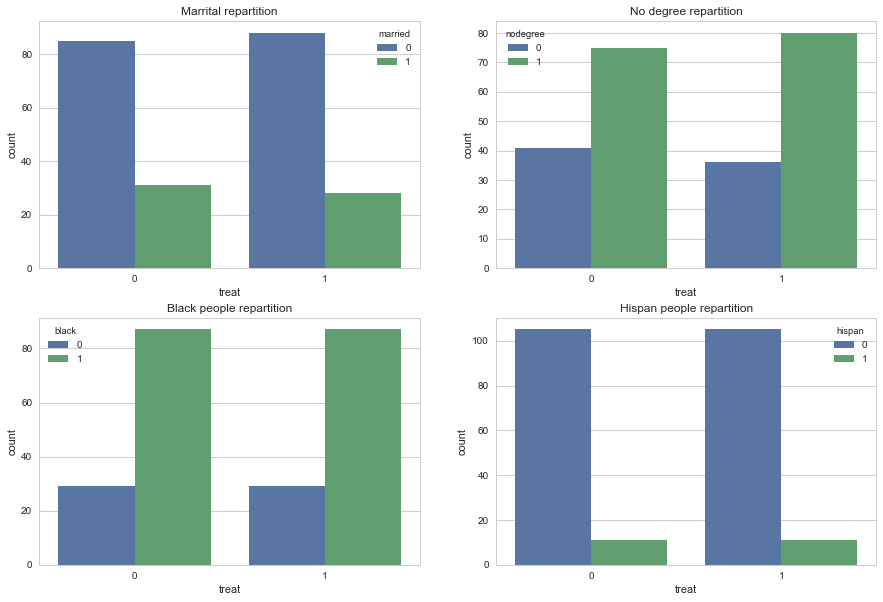

In [48]:
df = lalonde[lalonde['match_treat'] != -1]

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

ax[0, 0].set_title("Marrital repartition")
sns.countplot(x='treat', hue='married', data=df, ax=ax[0, 0])

ax[0, 1].set_title("No degree repartition")
sns.countplot(x='treat', hue='nodegree', data=df, ax=ax[0, 1])

ax[1, 0].set_title("Black people repartition")
sns.countplot(x='treat', hue='black', data=df, ax=ax[1, 0])

ax[1, 1].set_title("Hispan people repartition")
sns.countplot(x='treat', hue='hispan', data=df, ax=ax[1, 1])

Now all these features are very well balanced between the two groups compared to the last matching. Especially, the racial distributions are exactly the same.

The age distributions are also pretty equivalent :

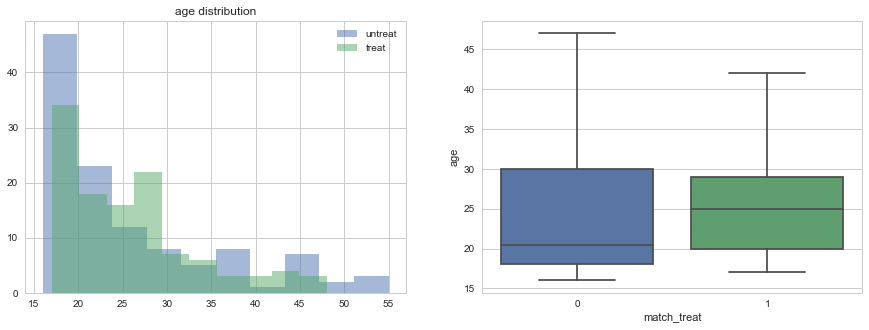

In [56]:
compare_feature('age', x='match_treat')

**Income distributions :**

In [58]:
display(describe_feature('re74', x='match_treat'))
display(describe_feature('re75', x='match_treat'))

,count,mean,std,min,25%,50%,75%,max
match_treat,,,,,,,,
0,116.0,2846.6,4818.6,0.0,0.0,515.3,2760.1,21918.3
1,116.0,2351.2,5536.0,0.0,0.0,0.0,1171.1,35040.1


,count,mean,std,min,25%,50%,75%,max
match_treat,,,,,,,,
0,116.0,1882.2,2943.7,0.0,0.0,555.0,2302.8,13776.5
1,116.0,1587.2,3128.6,0.0,0.0,0.0,1677.9,17976.2


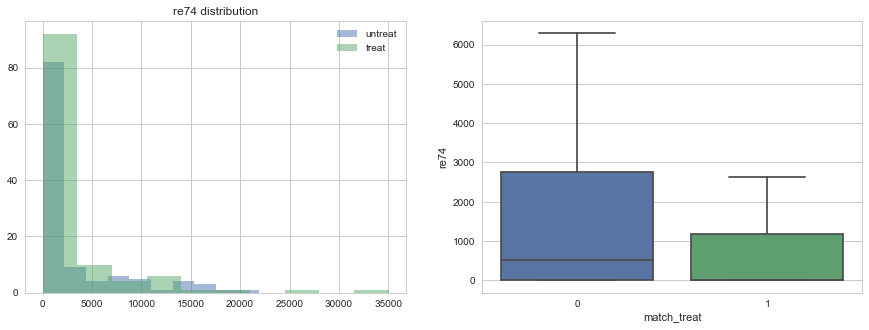

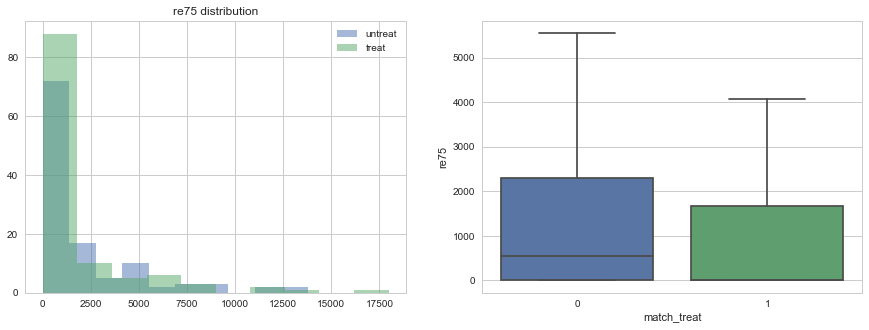

In [59]:
compare_feature('re74', x='match_treat')
compare_feature('re75', x='match_treat')

We can observe that the drawback of this new matching is that the incomes in 1974 and in 1975 are now less close between the two groups than with the first matching. It comes from the fact that the data set doesn't contains enough various profiles and in order to balance the racial distributions, the matching algorithm could not pick people who had both the same race and close incomes. These last two distributions are however still pretty close, at least in comparison to the very first distributions.

The matchings are now more balanced than with the first version : all the features have the same distributions among the two groups except the incomes which differ a little bit. Comparing the evolution of the incomes of two groups with the same social distributions make more sense than if the two groups had only the same income distributions because in the first case the people have equal chances and equal future prospects.

### 6. A less naive analysis

To compare these values, we update the categorical column **'match_treat'** in the **lalonde** data frame : 0 means that the person was matched and is untreated, and 1 means that the person was matched and treated (-1 means the person wasn't matched). We can then group by this categorical column and compare the different means obtained.

In [54]:
lalonde['match_treat'] = -1
lalonde.loc[new_untreat_matched, 'match_treat'] = 0
lalonde.loc[new_treat_matched, 'match_treat'] = 1

In [55]:
df = lalonde.groupby('match_treat').mean().round(1)
df

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
match_treat,,,,,,,,,,
-1,0.2,28.5,10.3,0.2,0.1,0.5,0.6,5747.1,2458.4,7246.7
0,0.0,25.2,10.2,0.8,0.1,0.3,0.6,2846.6,1882.2,4968.6
1,1.0,25.9,10.3,0.8,0.1,0.2,0.7,2351.2,1587.2,7122.5


This data frame summarizes everything. We see that in the two matched groups, the features **age**, **educ**, **black**, **hispan**, **married** and **nodegree** are very similar (at least the means are).

As stated before, the incomes in 1974 and 1975 are still closer than before any matching, but differ a lot of more than with the first matching.

We can clearly see that in the untreated group, the incomes are higher than in the treated one for both years 1974 and 1975, before the treatment. However, the incomes of the treated group are higher in average in 1978, after the treatment.

From these results, it seems like the treatment has a positive effect on the salaries of the participants. We could still improve the matchings with a bigger data set allowing to make salaries in 1974 and in 1975 closer between the two groups even though experiment would be ideal instead of an observational study.

## Question 2: Applied ML

We are going to build a classifier of news to directly assign them to 20 news categories. Note that the pipeline that you will build in this exercise could be of great help during your project if you plan to work with text!

### Importing useful functions form sklearn

In [167]:
from pprint import pprint
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV

### 1. TF-IDF

First we load the entire 20newsgroup dataset.

In [192]:
newsgroups = fetch_20newsgroups(subset='all')

target_names = np.array(newsgroups.target_names)

print('list of target names : \n')
pprint(list(target_names))

list of target names : 

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']


Compute TF-IDF features for every article using TfidfVectorizer (by first removing the english stop words).

In [193]:
tf_idf = TfidfVectorizer(stop_words="english")
tf_idf.fit(newsgroups.data);

Then, we split our dataset into a training, a testing and a validation set (10% for validation and 10% for testing)

In [194]:
X_train, X_test, y_train, y_test = train_test_split(newsgroups.data, target_names[newsgroups.target], 
                                                    train_size=0.8, test_size=0.2, 
                                                    stratify=newsgroups.target)

### 2. Random Forest

First, train a random forest on our training set using a pipeline

In [195]:
random_forest = RandomForestClassifier()
pipeline = Pipeline([('tf_idf', tf_idf), ('random_forest', random_forest)])
pipeline.fit(X_train, y_train);

In [196]:
prediction = pipeline.predict(X_test)
pipeline.score(X_test, y_test)

0.7657824933687003

Fine-tune the parameters of your predictor on your validation set using a simple grid search on the number of estimator "n_estimators" and the max depth of the trees "max_depth"

In [197]:
param_grid = {
    'random_forest__n_estimators': [10, 100, 1000],
    'random_forest__max_depth': [10, 100]
}
grid_search = GridSearchCV(pipeline, param_grid=param_grid, n_jobs=18)
grid_search.fit(X=X_train, y=y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('tf_idf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params={}, iid=True, n_jobs=18,
       param_grid={'random_forest__max_depth': [10, 100], 'random_forest__n_estimators': [10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

Then, display a confusion matrix of our classification pipeline

In [198]:
def plot_confusion_matrix(pred):
    # create the confusion matrix
    cm = confusion_matrix(y_test, pred, labels=newsgroups.target_names)
    # normalize it 
    cm = cm / cm.sum(axis=1)

    # create the figure to display the confusion matrix using seaborn
    f, ax = plt.subplots(1, 1, figsize=(18,12))
    sns.heatmap(cm, cmap='YlOrRd', vmin=0, vmax=1, annot=True, fmt='.2f', ax=ax, square=True, 
                xticklabels=target_names, yticklabels=target_names);
    ax.set_title('Confusion matrix of our classification pipeline');
    ax.set_ylabel('Real');
    ax.set_xlabel('Predicted');

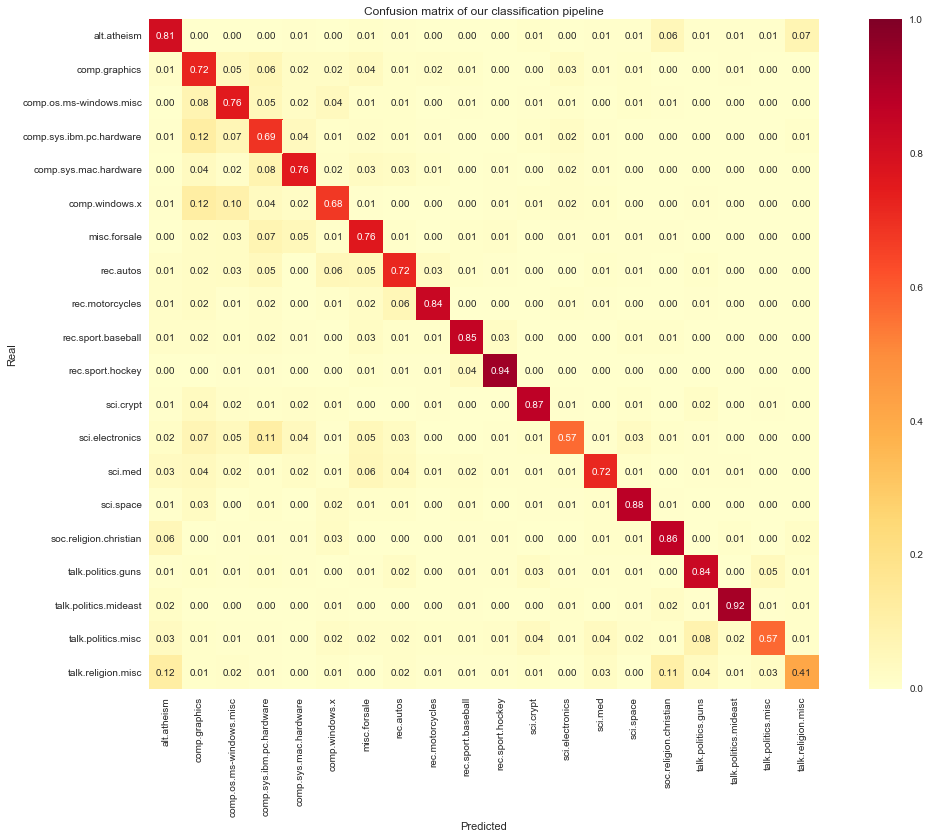

In [199]:
plot_confusion_matrix(prediction)

In [200]:
best_classifier = grid_search.best_estimator_
best_classifier.score(X_test, y_test)

0.87480106100795751

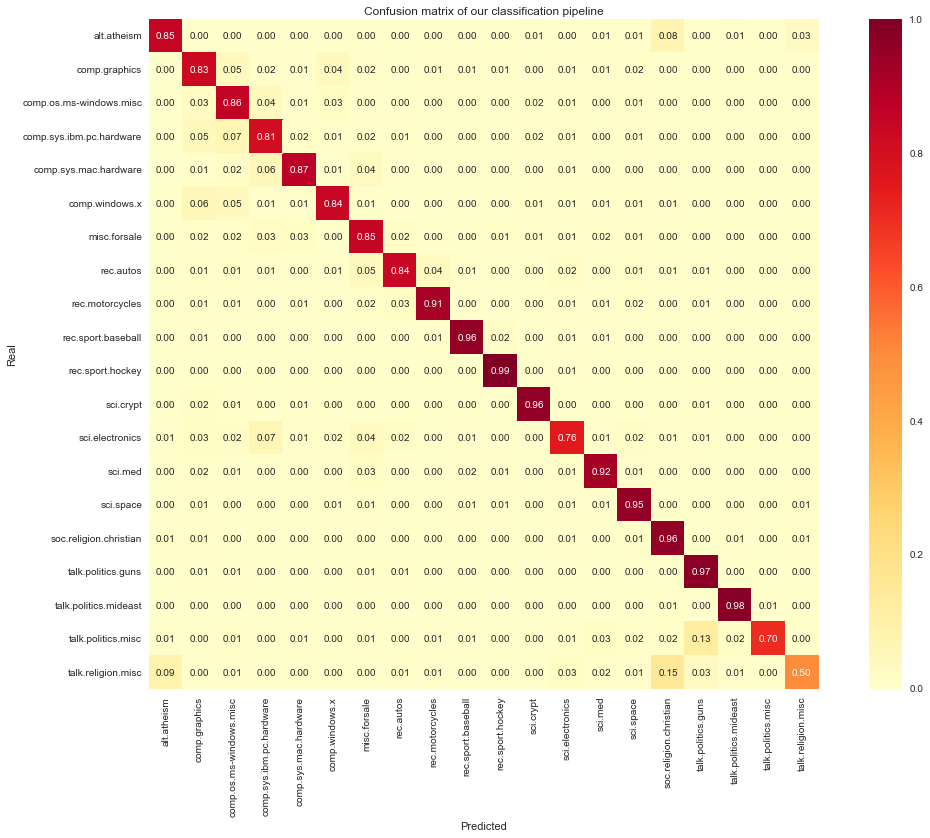

In [201]:
prediction2 = best_classifier.predict(X_test)
plot_confusion_matrix(prediction2)

Lastly, we inspect the feature\_importances\_ attribute of our random forest

In [202]:
tf_idf = pipeline.steps[0][1]
random_forest = pipeline.steps[1][1]
sorted_terms = [term for term, score in sorted(tf_idf.vocabulary_.items(), key=lambda x: x[1])]

feature_importances_df = pd.DataFrame({'importance': random_forest.feature_importances_})
feature_importances_df.index = sorted_terms
feature_importances_df = feature_importances_df.sort_values(by='importance', ascending=False)

feature_importances_df.head(10)

,importance
sale,0.008548
dod,0.004871
israel,0.004226
windows,0.004176
clipper,0.004011
bike,0.003966
mac,0.003914
hockey,0.003854
space,0.003592
rutgers,0.003119
